In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# import data
data = pd.read_csv('../../Data/Fremont_Bridge_Bicycle_Counter.csv', index_col='Date', parse_dates=True)
data.columns = ['Total', 'East', 'West']

In [69]:
data.sort_index(inplace=True)

In [70]:
data_daily = data.resample('D').sum()

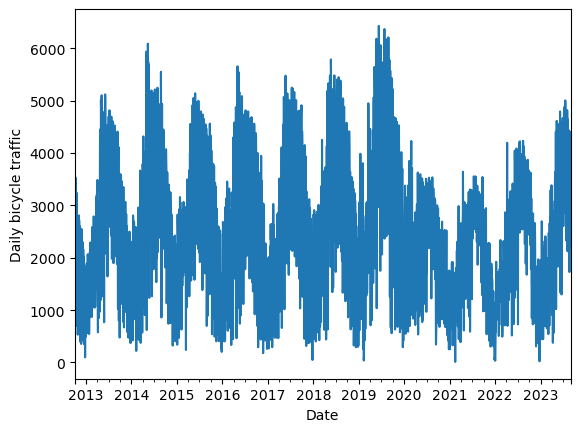

In [71]:
# plot daily traffic, data currently hourly
data_daily['Total'].resample('D').sum().plot()
plt.ylabel('Daily bicycle traffic')
plt.show()

#### Goal: Predict daily traffic based on:
- day of the week
- year (upward trend? more ppl)
- holidays
- hours of daylight
- weather (temp, precipitation, wind speed, etc)
- hour of the day

In [72]:
weather_data = pd.read_csv('../../Data/Seattle_weather_102012_082023.csv', index_col='DATE', parse_dates=True)

#### Weather data variables:
- WT03 - Thunder
- WT04 - Ice pellets, sleet, snow pellets, or small hail"
- PRCP - Precipitation
- WT05 - Hail (may include small hail)
- WT06 - Glaze or rime
- WT08 - Smoke or haze
- SNWD - Snow depth
- WT09 - Blowing or drifting snow
- WDF2 - Direction of fastest 2-minute wind
- WDF5 - Direction of fastest 5-second wind
- PGTM - Peak gust time
- TMAX - Maximum temperature
- WT13 - Mist
- WSF2 - Fastest 2-minute wind speed
- WSF5 - Fastest 5-second wind speed
- SNOW - Snowfall
- WT14 - Drizzle
- WT16 - Rain (may include freezing rain, drizzle, and freezing drizzle)"
- WT18 - Snow, snow pellets, snow grains, or ice crystals
- AWND - Average wind speed
- WT22 - Ice fog or freezing fog
- WT01 - Fog, ice fog, or freezing fog (may include heavy fog)
- WT02 - Heavy fog or heaving freezing fog (not always distinguished from fog)
- TAVG - Average Temperature.
- TMIN - Minimum temperature

In [73]:
# add times features
data_daily['Day'] = data_daily.index.dayofweek
data_daily['Month'] = data_daily.index.month
data_daily['Year'] = data_daily.index.year
# 'covid column' 0 pre covid, 1 post covid (2020-03-01)
data_daily['Covid'] = np.where(data_daily.index >= '2020-03-01', 1, 0)

In [74]:
# add holiday feature
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=data_daily.index.min(), end=data_daily.index.max())
data_daily['Holiday'] = data_daily.index.isin(holidays)

In [76]:
data_daily.loc[data_daily['Holiday'] == 1]

,Total,East,West,Day,Month,Year,Covid,Holiday
Date,,,,,,,,
2012-10-08,3537.0,1829.0,1708.0,0,10,2012,0,True
2012-11-12,1631.0,839.0,792.0,0,11,2012,0,True
2012-11-22,554.0,325.0,229.0,3,11,2012,0,True
2012-12-25,98.0,50.0,48.0,1,12,2012,0,True
2013-01-01,678.0,344.0,334.0,1,1,2013,0,True
...,...,...,...,...,...,...,...,...
2023-01-16,1622.0,692.0,930.0,0,1,2023,1,True
2023-02-20,653.0,271.0,382.0,0,2,2023,1,True
2023-05-29,2414.0,1103.0,1311.0,0,5,2023,1,True


In [83]:
def get_hours_daylight(date):
    axis = np.radians(23.44) # tilt of earth axis
    latitude = np.radians(47.61) # seattle lat
    days = (date - pd.to_datetime('2000-12-31')).days

    m = (1 - np.tan(latitude) * np.tan(axis*np.cos(days*2*np.pi/365.25)))
    hours_of_daylight = 24 * np.degrees(np.arccos(1 - m)) / 180
    return hours_of_daylight

In [87]:
data['hours_of_daylight'] = data.index.map(get_hours_daylight)